In [52]:
import numpy as np
import scipy
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt

# Homework 2
## Hypothesis testing

Each task is worth 5 points, 20 points in total. Additionally, some tasks allow you to get a bonus point, that **can not** increase your total score for the homework beyond the maximum, but can compensate for some occasionally lost points.

### Task 1: multiple comparisons

A randomized, double-blind experiment was conducted to assess the
effectiveness of several drugs for reducing postoperative nausea. The
data are as follows:

In [53]:
df1 = pd.DataFrame({'Drug': ['Placebo', 'Chlorpromazine', 'Dimenhydrinate', 'Pentobarbital (100 mg)', 'Pentobarbital (150 mg)'],
                    'Number of Patients': [80, 75, 85, 67, 85],
                    'Incidence of Nausea': [45, 26, 52, 35, 37]})
df1

,Drug,Number of Patients,Incidence of Nausea
0,Placebo,80,45
1,Chlorpromazine,75,26
2,Dimenhydrinate,85,52
3,Pentobarbital (100 mg),67,35
4,Pentobarbital (150 mg),85,37


1. Test each drug versus the placebo at the 5% level. Also, report
the estimated odds–ratios. Summarize your findings. (2 points)
2. Use the Bonferroni and the FDR method to adjust for multiple
testing. (Beecher (1959)) (3 points)
3. Reproduce plot similar to Figure 10.6 from the book, displaying observed $p$-values and different thresholds used (1 bonus point)

*Hint*. Use simple $H_0$: "$\mathbb{P}_{drug} = \mathbb{P}_{placebo}$".

### 1)

In [54]:
alpha = .05

placebo = df1[df1.Drug == 'Placebo']
placebo_mean = placebo['Incidence of Nausea'] / placebo['Number of Patients']

walds_vals_list = []
pvals_walds = []

for _, row in df1[1:].iterrows():
    n, m = row['Number of Patients'], placebo['Number of Patients']
    
    mean = row['Incidence of Nausea'] / n
    
    std = np.sqrt(mean * (1 - mean) / n + \
                placebo_mean * (1 - placebo_mean) / m)
    
    delta = mean - placebo_mean
    
    w_val = abs(delta / std)
    
    odd_ratio = (row['Incidence of Nausea'] / (n - row['Incidence of Nausea'])) \
          / (placebo['Incidence of Nausea'] / (m - placebo['Incidence of Nausea']))
                 
    print(row.Drug, 'odd ratio:', '%.3f' % odd_ratio)
    
    walds_vals_list.append((row.Drug, w_val))
    pval = 2 * (1 - sps.norm.cdf(w_val))
    pvals_walds.append(*pval)

print('\nAccording to the Wald\'s test:\n')
    
for x in walds_vals_list:
    ans = x[1] > sps.norm.ppf(1 - alpha / 2)
    verdict = ' NOT' if ans.bool() else ''
     
    print(x[0], ' is', verdict, ' a placebo', sep='')

Chlorpromazine odd ratio: 0.413
Dimenhydrinate odd ratio: 1.226
Pentobarbital (100 mg) odd ratio: 0.851
Pentobarbital (150 mg) odd ratio: 0.600

According to the Wald's test:

Chlorpromazine is NOT a placebo
Dimenhydrinate is a placebo
Pentobarbital (100 mg) is a placebo
Pentobarbital (150 mg) is a placebo


### 2)

In [55]:
from statsmodels.stats.multitest import multipletests

In [56]:
pvals_walds

[0.005703391555257786,
 0.5202323654229462,
 0.6266640947313886,
 0.09963923341820236]

In [57]:
method='bonferroni'
reject, b_list, _, _ = multipletests(pvals=pvals_walds, alpha=alpha, method=method, returnsorted=True)    
print(f"Method {method:10s}: reject = {reject}\n with p-values = {b_list}\n")

method='fdr_bh'
reject, fdr_list, _, _ = multipletests(pvals=pvals_walds, alpha=alpha, method=method, returnsorted=True)    
print(f"Method {method:10s}: reject = {reject}\n with p-values = {fdr_list}")

Method bonferroni: reject = [ True False False False]
 with p-values = [0.02281357 0.39855693 1.         1.        ]

Method fdr_bh    : reject = [ True False False False]
 with p-values = [0.02281357 0.19927847 0.62666409 0.62666409]


### Thus, it approves our corrolary from single Wald's test(only 1st drug not a placebo)

### 3)

In [58]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

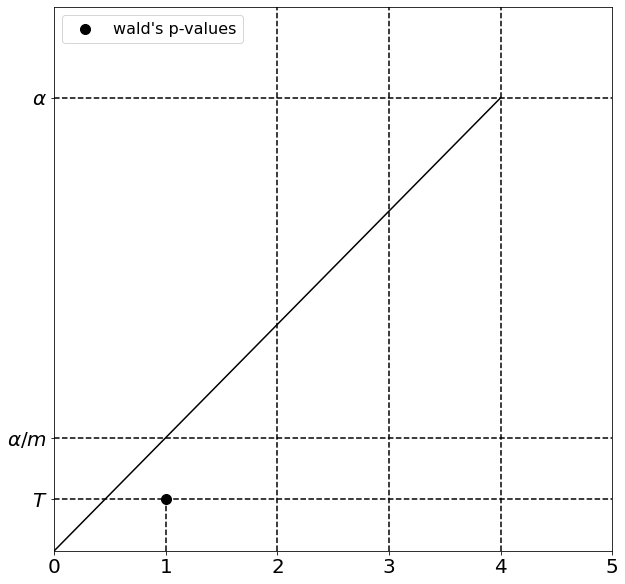

In [59]:
plt.figure(figsize=(10, 10))

m = df1[1:].shape[0]

lists = [pvals_walds, b_list, fdr_list]

plt.scatter(np.arange(1, 5, 1), lists[0], c='k', s=100, label='wald\'s p-values')
for i, val in zip(range(1, 5), lists[0]):
    plt.plot((i, i), (0, val), 'k--')

x = np.arange(0, 5, 1)
y = alpha * x / m
plt.plot(x, y, 'k')

y_ticks = [alpha, alpha / m, pvals_walds[0]]
y = plt.gca().set_yticks(y_ticks)

plt.hlines(y_ticks, color="k", ls="--", xmin=0, xmax=5)

labels = plt.gca().get_yticks().tolist()
labels = [r'$\alpha$', r'$\alpha/ m$', r'$T$']
plt.gca().set_yticklabels(labels)

plt.ylim(0, alpha + 1e-2)
plt.xlim(0, 5)
plt.legend(prop={"size":16})
plt.show()

### Task 2: permutation test

In [60]:
df2 = pd.DataFrame({'person': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'], 
                    'left': [17.5, 18.4, 16.2, 14.5, 13.5, 18.9, 19.5, 21.1, 17.8, 16.8, 18.4, 17.3, 18.9, 16.4, 17.5, 15], 
                    'right': [17.6, 18.5, 15.9, 14.9, 13.7, 18.9, 19.5, 21.5, 18.5, 17.1, 18.9, 17.5, 19.5, 16.5, 17.4, 15.6]})
df2.head()

,person,left,right
0,A,17.5,17.6
1,B,18.4,18.5
2,C,16.2,15.9
3,D,14.5,14.9
4,E,13.5,13.7


We are interested in comparing the length of left hands and rights from 16 individuals. 

1. Compare histograms for left and right hands length (0.5 points)
2. Calculate independent samples permutation test (2 points)
3. Draw scatter plot for left and right hands length (0.5 points)
4. Calculate paires permutation test (2 points)
5. Which test performs better in this case? Why? (1 point)

In [61]:
x = df2['left']
y = df2['right']

### 1)

In [62]:
plt.rcParams.update({'font.size': 16})

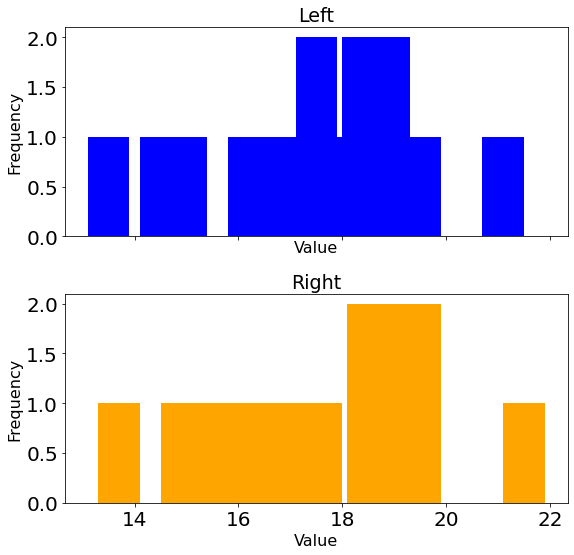

In [63]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=True)

vals, counts = np.unique(x, return_counts=True)
ax[0].bar(x=vals, height=counts, color='blue')
ax[0].set_title('Left')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Frequency')

vals, counts = np.unique(y, return_counts=True)
ax[1].bar(x=vals, height=counts, color='orange')
ax[1].set_title('Right')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### 2)

In [64]:
statistic, pvalue = sps.ttest_ind(x, y)
f"Got statistic = {statistic:.3f} with p-value = {pvalue:.3f}"

'Got statistic = -0.343 with p-value = 0.734'

### 3)

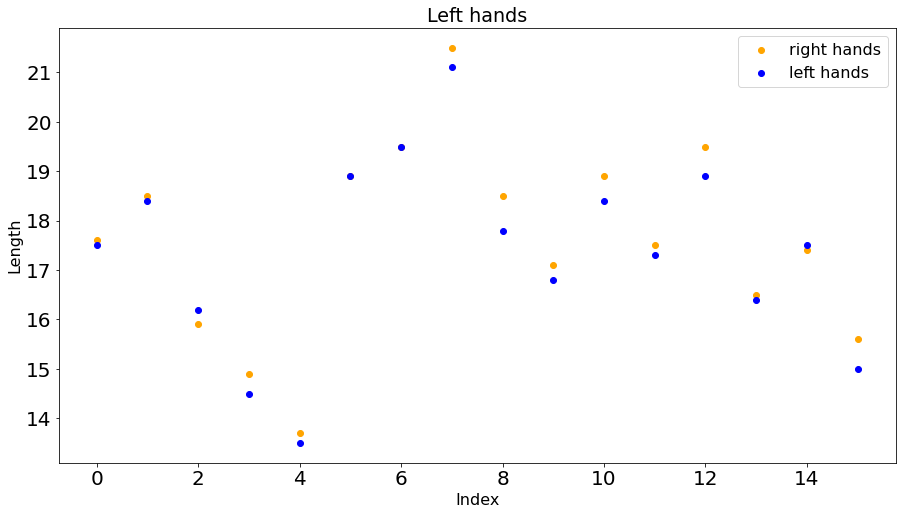

In [77]:
plt.figure(figsize=(15, 8))

plt.scatter(df2.index, y, c='orange', label='right hands')
plt.scatter(df2.index, x, c='blue', label='left hands')

plt.title('Left hands')
plt.xlabel('Index')
plt.ylabel('Length')

plt.legend()
plt.show()

In [78]:
bound = x.shape[0]
bound

16

In [79]:
from numpy.random import choice

In [97]:
n_runs = 1000

t_obs = np.abs(x.mean() - y.mean())

indicator_cnt = 0.

for _ in range(n_runs):
    
    x_temp, y_temp = np.array(x), np.array(y)
    
    for i, _ in enumerate(x_temp):
        if choice([0, 1]) == 1:
            x_temp[i], y_temp[i] = y_temp[i], x_temp[i]
    
    t = np.abs(x_temp.mean() - y_temp.mean())
    
    if t > t_obs:
        indicator_cnt += 1.

p_val = indicator_cnt / n_runs
p_val

0.001

### 5)

In [98]:
print(f'IPT: {pvalue:.3f} vs PPT: {p_val:.3f}')

IPT: 0.734 vs PPT: 0.001


#### According to PPT we have to reject $H_0$

### Both p-values do not allow us to reject the $H_0$, if considered level of significance is $\alpha = 0.05$

### Task 3: computational approach to hypothesis testing

Recommended reading: http://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html

Consider the following dataset (service hours between failures of the air-conditioning equipment in a Boeing 720 jet aircraft , Proschan, 1963):

In [174]:
Y = np.array([3, 5, 7, 18, 43, 85, 91, 98, 100, 130, 230, 487])

This sample was sorted for easier presentation.

1. Compute an estimate of the median time between failures (1 point)
2. Consider the null hypothesis $H_0$ to be: "median time between failures is one week" (1 point)
3. What family of distributions will you choose for this kind of data under $H_0$? (1 point)
4. Choose a test statistic to measure the deviation from $H_0$ (1 point)
5. Check whether you can reject $H_0$ at significance level 5% and calculate the corresponding approximate $p$-value. Use 10,000 simulations for your experiment (1 point)
6. Plot histogram of the simulated values of the test statistic and mark the observed value and threshold that you obtained (1 bouns point)

### 1)

In [175]:
median = np.median(Y)
median

88.0

### 2)

In [176]:
hypothesis_median = 7 * 24 
hypothesis_median

168

### 3)

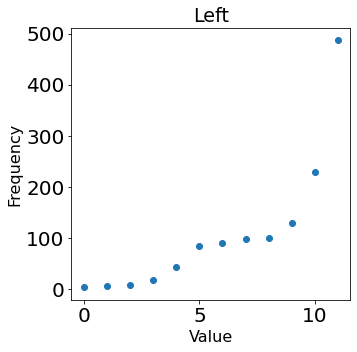

In [177]:
plt.figure(figsize=(5, 5))

plt.scatter(range(Y.shape[0]), Y)

plt.title('Left')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

### Looks like $Y$ has exponential distribution

### 4)

### The Wald test statistic is $W = \hat{\delta}$ / $\hat{se}$

Where:

$\hat{\delta} = \hat{\nu_1} - \hat{\nu_2}$, where $\hat{\nu_1}$ and $\hat{\nu_2}$ are the sample medians,

$\hat{se}$ obtained from non-parametric bootstrap.

### 5)

We also will need to obtain median from following ratiо:

$median = \frac{\ln2}{\lambda}$,

where $\lambda$ is a parameter of exponential distribution.

In [187]:
n_simulations = 10000
param_lambda = np.log(2) / hypothesis_median

t_boot = np.empty(n_simulations)

indicator_cnt = 0.

for i in range(n_simulations):

    sample = sps.expon.rvs(scale=1/param_lambda, size=Y.shape[0])
    t_boot[i] = np.median(sample)
    
std = np.std(t_boot)
    
w_val = (median - hypothesis_median) / std

reject = np.abs(w_val) > sps.norm.ppf(1 - alpha / 2)
reject

False

In [188]:
w_val

-1.1769863487705585

In [189]:
print('p-value:', 2 * (1 - sps.norm.cdf(abs(w_val))))

p-value: 0.23920095497852412


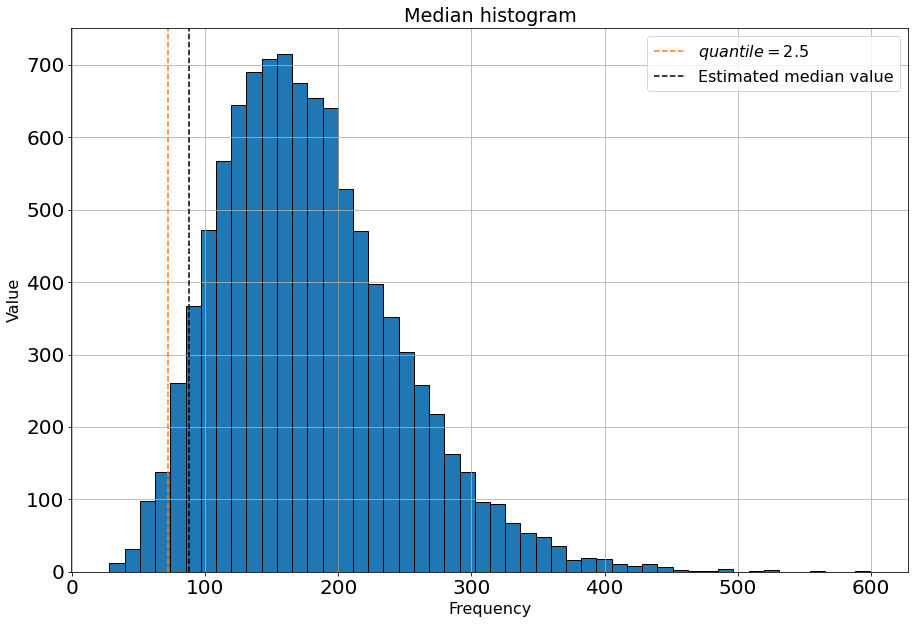

In [240]:
plt.figure(figsize=(15, 10))

plt.hist(t_boot, bins=50, edgecolor='black')
plt.title('Median histogram')

plt.axvline(np.quantile(t_boot, 0.025), 0, 1, color='C1', label=r'$quantile = 2.5%$', ls='--')
plt.axvline(median, 0, 1, color='black', label="Estimated median value", ls='--')

plt.xlabel('Frequency')
plt.ylabel('Value')

plt.legend()
plt.grid()
plt.show()

### Task 4

In 1861, 10 essays appeared in the New Orleans Daily Crescent. They
were signed “Quintus Curtius Snodgrass” and some people suspected
they were actually written by Mark Twain. To investigate this, we will
consider the proportion of three letter words found in an author’s work.
From eight Twain essays we have:

In [241]:
X = np.array([.225, .262, .217, .240, .230, .229, .235, .217])

From 10 Snodgrass essays we have:

In [242]:
Y = np.array([.209, .205, .196, .210, .202, .207, .224, .223, .220, .201])

1. Perform a Wald test for equality of the means. Use the nonparametric plug-in estimator. Report the $p$-value and a 95% confidence
interval for the difference of means. What do you conclude? (1.5 points)
2. Now use a permutation test to avoid the use of large sample methods.
What is your conclusion? (Brinegar (1963)) (1.5 points)
3. Assume that samples do indeed come from different populations. Additionally, observed sample means and variaces for the two samples are equal to the true values for the respective population. Estimate the power of the two tests above under two model distributions for the data: Normal and [Beta](https://en.wikipedia.org/wiki/Beta_distribution) (use the same family for both samples) (2 points)

### 1)

In [243]:
n, m = X.shape[0], Y.shape[0]
x_mean, y_mean = X.mean(), Y.mean()

std = np.sqrt(np.var(X) / n + np.var(Y) / m)
    
delta = x_mean - y_mean
    
w_val = abs(delta / std)

In [244]:
z = sps.norm.ppf(1 - alpha / 2)

(lower, upper) = delta - z * std, delta + z * std
f"Theta {delta:.3f} with normal-based confidence interval ({lower:.3f}, {upper:.3f})"

'Theta 0.022 with normal-based confidence interval (0.011, 0.033)'

### $0.0$ does not lay in CI

In [245]:
pval = 2 * (1 - sps.norm.cdf(w_val))
pval

7.992664956146811e-05

### 2)

In [246]:
statistic, pvalue = sps.ttest_ind(X, Y)
f"Got statistic = {statistic:.3f} with p-value = {pvalue:.3f}"

'Got statistic = 3.878 with p-value = 0.001'

### We conclude, that it's diffent distribution according to both criteria

### 3)